### imports

In [1]:
from varElimination import *
from gibbs_sampling import *
from scipy.stats import sem, t
from tqdm import tqdm

In [2]:
def get_n_mc(var, evi_dict = None, step = 1500, burn_in = 500, n_chains = 10):
    data = {}
    for i in tqdm(range(n_chains)):
        data[i] = gibbs.query(var, evi_dict, step, burn_in)
    df = pd.DataFrame(data)
    return df

In [3]:
confidence = 0.95
def get_mean_ci(df):
    steps = df.shape[0] # same as num of samples
    n = df.shape[1] # same as num of chains
    mean, lb, ub = [],[],[]
    df_m = df.as_matrix()
    for step in range(steps):
        m = np.mean(df_m[step])
        mean.append(m)
        h0 = sem(df_m[step]) * t.ppf((1 + confidence) / 2, n - 1)
        ub.append(m + h0)
        lb.append(m - h0)
    return mean, lb, ub

In [4]:
def plot_gibbs(mean, lb, ub, true_prob):
    plt.fill_between(range(len(mean)), ub, lb, color= 'tab:orange', alpha=.5, label = '95% CI')
    plt.axhline(y=true_prob[0], color='r', linestyle='--', label = 'true_0_prob')
    plt.plot(range(len(mean)), mean, linestyle='-', label = 'gibbs_0_prob')
    plt.legend(loc = 'best')
    plt.xlabel('step')
    plt.ylabel('average_expected_prob')
    plt.rcParams["figure.figsize"] = (20,10)
    plt.show()

### Problem setting

A critical valve in a steam plant may be in one of two states: normal or broken. The state of the valve changes over time according to Markovian dynamics (the next state only depends on the previous state). The initial valve state is normal. If the current valve state is broken, the next valve state must be broken. If the current valve state is normal, the next valve state has a 0.2 probability of becoming broken. We model the valve state over 3 consecutive time steps (i.e., first time step, second time step, third time step).

Note: This is not a continuous time model and we do not care about the exact times. We simply have 3 different discrete random variables for valve state corresponding to the valve state at 3 consecutive time steps.

A very noisy sensor monitors the valve state at every time step. The sensor may take on one of two assignments: observed_normal or observed_broken. If the valve state is normal, there is a uniform (i.e., equal) probability of the sensor reading either observed_normal or observed_broken. If the valve state is broken, then the sensor will always read observed_broken.

Answer the following questions, by showing the code that executes the query and produces the exact numerical result:

Q1: 

Given no evidence, what is the probability that the valve state is broken at the third time step?

Q2:

Given the evidence observed_broken for the sensor at the second time step, what is the probability that the valve state is broken at the third time step?

Q3:

Given the sensor observation sequence (observed_broken, observed_normal, observed_broken) as evidence, what is the probability that the valve state is broken at the third time step?

In [5]:
warm_up = BayesModel([('V1','S1'),('V1','V2'),('V2','S2'),('V2','V3'),('V3','S3')])
cpd_V1 = TabularCPD('V1', values = [[0,1]])
cpd_S1_V1 = TabularCPD('S1', values = [[1,0.5],[0,0.5]], evidence = ['V1'])
cpd_S2_V2 = TabularCPD('S2', values = [[1,0.5],[0,0.5]], evidence = ['V2'])
cpd_S3_V3 = TabularCPD('S3', values = [[1,0.5],[0,0.5]], evidence = ['V3'])
cpd_V2_V1 = TabularCPD('V2', values = [[1,0.2],[0,0.8]], evidence = ['V1'])
cpd_V3_V2 = TabularCPD('V3', values = [[1,0.2],[0,0.8]], evidence = ['V2'])

In [6]:
warm_up.add_cpds(cpd_V1,cpd_S1_V1,cpd_S2_V2,cpd_S3_V3,cpd_V2_V1,cpd_V3_V2)

In [7]:
gibbs = GibbsSampling(warm_up)
infer = VarElimination(warm_up)

In [8]:
true_prob1 = infer.query(['V3']).p.to_list()
true_prob1

[0.36, 0.64]

In [9]:
true_prob2 = infer.query(['V3'],{'S2':0}).p.to_list()
true_prob2

[0.4666666666666666, 0.5333333333333333]

In [10]:
true_prob3 = infer.query(['V3'],{'S1':0,'S2':1,'S3':0}).p.to_list()
true_prob3

[0.3333333333333333, 0.6666666666666666]

### q1

100%|██████████| 10/10 [28:01<00:00, 167.02s/it]


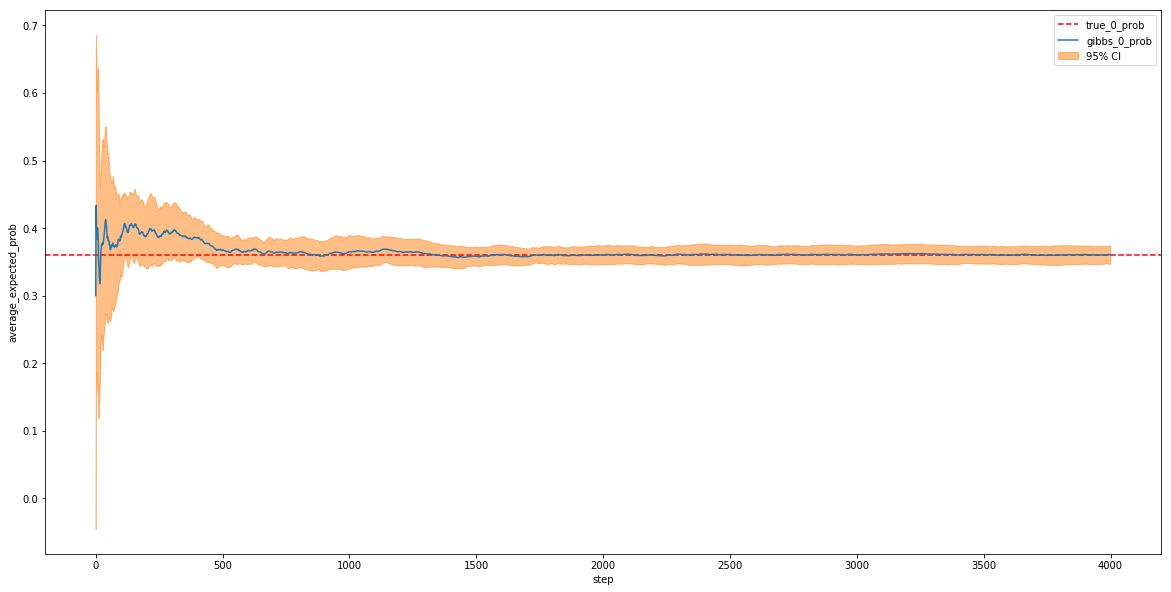

In [14]:
df1 = get_n_mc('V3', evi_dict = {}, step = 4000, burn_in = 1000, n_chains = 10)
m1,lb1,ub1 = get_mean_ci(df1)
plot_gibbs(m1,lb1,ub1, true_prob1)

apart from the 1000 burn-in samples, the sampler took around 1800 samples to asymptote the exact solution

### q2

100%|██████████| 10/10 [26:34<00:00, 158.65s/it]


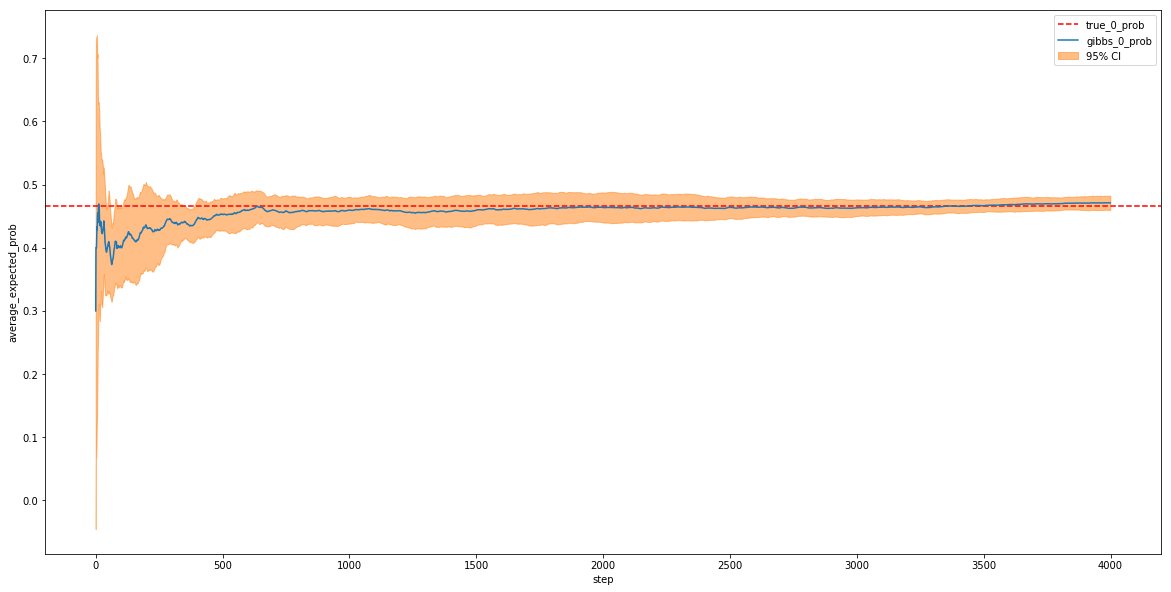

In [15]:
df2 = get_n_mc('V3', evi_dict = {'S2':0}, step = 4000, burn_in = 1000, n_chains = 10)
m2,lb2,ub2 = get_mean_ci(df2)
plot_gibbs(m2,lb2,ub2, true_prob2)

apart from the 1000 burn-in samples, the sampler took around 3000 more samples to asymptote the exact solution

### q3

In [11]:
df3 = get_n_mc('V3', evi_dict = {'S1':0,'S2':1,'S3':0}, step = 3000, burn_in = 1000, n_chains = 10)
m3,lb3,ub3 = get_mean_ci(df3)

100%|██████████| 10/10 [19:40<00:00, 119.00s/it]


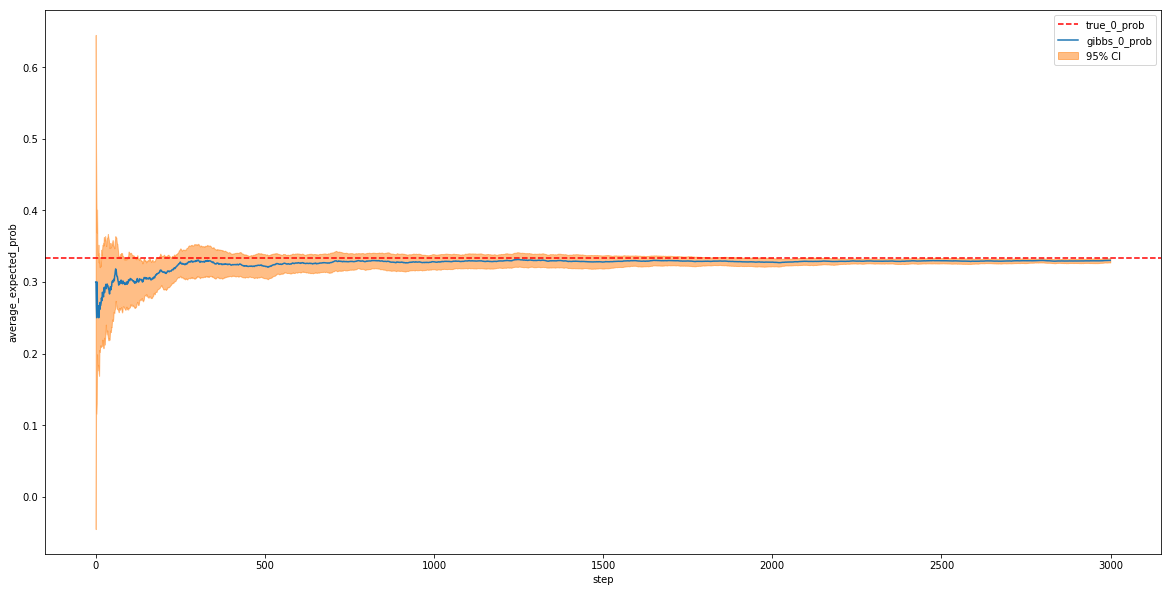

In [13]:
plot_gibbs(m3,lb3,ub3, true_prob3)

apart from the 1000 burn-in samples, the sampler took around 1500 more samples to asymptote the exact solution

